# ELO Timeline Box Plot Analysis

This notebook visualizes the distribution of model ELO ratings over time (by quarter), comparing all models vs reasoning models only.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
elo_df = pd.read_csv('../data_processing/elo_refined.csv')
metadata_df = pd.read_csv('../data_processing/models_metadata.csv')

print(f"ELO data: {len(elo_df)} models")
print(f"Metadata: {len(metadata_df)} models")
print(f"\nELO columns: {elo_df.columns.tolist()}")
print(f"Metadata columns: {metadata_df.columns.tolist()}")


ELO data: 136 models
Metadata: 205 models

ELO columns: ['Player', 'total_games', 'player_wins', 'opponent_wins', 'draws', 'player_wins_percent', 'player_draws_percent', 'average_moves', 'moe_average_moves', 'total_moves', 'player_wrong_actions', 'player_wrong_moves', 'wrong_actions_per_1000moves', 'wrong_moves_per_1000moves', 'mistakes_per_1000moves', 'moe_mistakes_per_1000moves', 'player_avg_material', 'opponent_avg_material', 'material_diff_player_llm_minus_opponent', 'moe_material_diff_llm_minus_rand', 'completion_tokens_black_per_move', 'moe_completion_tokens_black_per_move', 'moe_black_llm_win_rate', 'moe_draw_rate', 'moe_black_llm_loss_rate', 'win_loss', 'moe_win_loss', 'win_loss_non_interrupted', 'moe_win_loss_non_interrupted', 'game_duration', 'moe_game_duration', 'games_interrupted', 'games_interrupted_percent', 'moe_games_interrupted', 'games_not_interrupted', 'games_not_interrupted_percent', 'moe_games_not_interrupted', 'average_game_cost', 'moe_average_game_cost', 'price_p

## Metadata Coverage Verification

Check which models from ELO data have matching metadata.


In [2]:
# Clean up metadata model names
metadata_df['model'] = metadata_df['model'].str.strip()
metadata_df['date_released'] = metadata_df['date_released'].str.strip()

# Check metadata coverage for each model (exact match only)
metadata_models = set(metadata_df['model'])

models_with_metadata = [p for p in elo_df['Player'] if p in metadata_models]
models_missing_metadata = [p for p in elo_df['Player'] if p not in metadata_models]

total_count = len(elo_df)
missing_count = len(models_missing_metadata)

print(f"=" * 80)
print(f"METADATA COVERAGE SUMMARY")
print(f"=" * 80)
print(f"Total models in ELO data: {total_count}")
print(f"Models with metadata:     {total_count - missing_count} ({100*(total_count-missing_count)/total_count:.1f}%)")
print(f"Models WITHOUT metadata:  {missing_count} ({100*missing_count/total_count:.1f}%)")
print(f"=" * 80)
print()
print("All models from ELO data:")
print("-" * 80)
# First print models without metadata
for player in elo_df['Player']:
    if player not in metadata_models:
        print(f"✗ MISSING {player}")

# Then print models with metadata
for player in elo_df['Player']:
    if player in metadata_models:
        print(f"✓ {player}")


METADATA COVERAGE SUMMARY
Total models in ELO data: 136
Models with metadata:     136 (100.0%)
Models WITHOUT metadata:  0 (0.0%)

All models from ELO data:
--------------------------------------------------------------------------------
✓ gpt-5-nano-2025-08-07-high
✓ ring-mini-2.0@q8_0
✓ gpt-oss-20b-high
✓ gpt-oss-120b-low
✓ gpt-5-chat-2025-08-07
✓ gpt-5-mini-2025-08-07-medium
✓ gpt-5-nano-2025-08-07-medium
✓ qwen3-4b-thinking-2507@q8
✓ gpt-oss-120b-medium
✓ gpt-5-mini-2025-08-07-high
✓ qwen3-30b-a3b-thinking-2507@q4_k_m
✓ claude-sonnet-4-5-20250929_thinking_16000
✓ claude-haiku-4-5-20251001_thinking_16000
✓ gpt-5-mini-2025-08-07-low
✓ gpt-oss-20b-medium
✓ gpt-oss-20b-low
✓ claude-sonnet-4-5-20250929
✓ claude-opus-4-1-20250805
✓ gpt-oss-120b-high
✓ qwen2.5-7b-chess-mmxl@f16
✓ claude-haiku-4-5-20251001
✓ gpt-5-2025-08-07-low
✓ k2-think@iq4_xs
✓ kimi-k2-instruct
✓ gpt-5-nano-2025-08-07-low
✓ qwen-3-235b-a22b-instruct-2507
✓ grok-3-mini-beta
✓ claude-3-7-sonnet-20250219
✓ gemma-3-4b-it@i

## Data Preprocessing

Merge datasets and extract year/quarter from release dates.


In [3]:
# Merge datasets - exact match on Player column
merged_df = elo_df.merge(metadata_df, left_on='Player', right_on='model', how='inner')
print(f"Merged: {len(merged_df)} models matched")

# Filter out rows without valid ELO or date
merged_df = merged_df[merged_df['elo'].notna() & merged_df['date_released'].notna()]
merged_df = merged_df[merged_df['date_released'] != '']

print(f"After filtering: {len(merged_df)} models with valid ELO and date")

# Parse date_released to extract year and quarter
# Format is "YYYY-MM"
def get_year_quarter(date_str):
    try:
        parts = date_str.split('-')
        year = int(parts[0])
        month = int(parts[1])
        quarter = (month - 1) // 3 + 1
        return f"{year}-Q{quarter}"
    except:
        return None

merged_df['year_quarter'] = merged_df['date_released'].apply(get_year_quarter)
merged_df = merged_df[merged_df['year_quarter'].notna()]

print(f"\nFinal dataset: {len(merged_df)} models")
print(f"\nQuarters represented: {sorted(merged_df['year_quarter'].unique())}")
print(f"\nReasoning status distribution:")
print(merged_df['reasoning_status'].value_counts())


Merged: 136 models matched
After filtering: 88 models with valid ELO and date

Final dataset: 88 models

Quarters represented: ['2023-Q2', '2024-Q1', '2024-Q2', '2024-Q3', '2024-Q4', '2025-Q1', '2025-Q2', '2025-Q3', '2025-Q4']

Reasoning status distribution:
reasoning_status
reasoning        44
not_reasoning    42
unknown           2
Name: count, dtype: int64


## Box Plot Visualization

Box plots showing ELO distribution per quarter, with separate series for all models and reasoning models only.


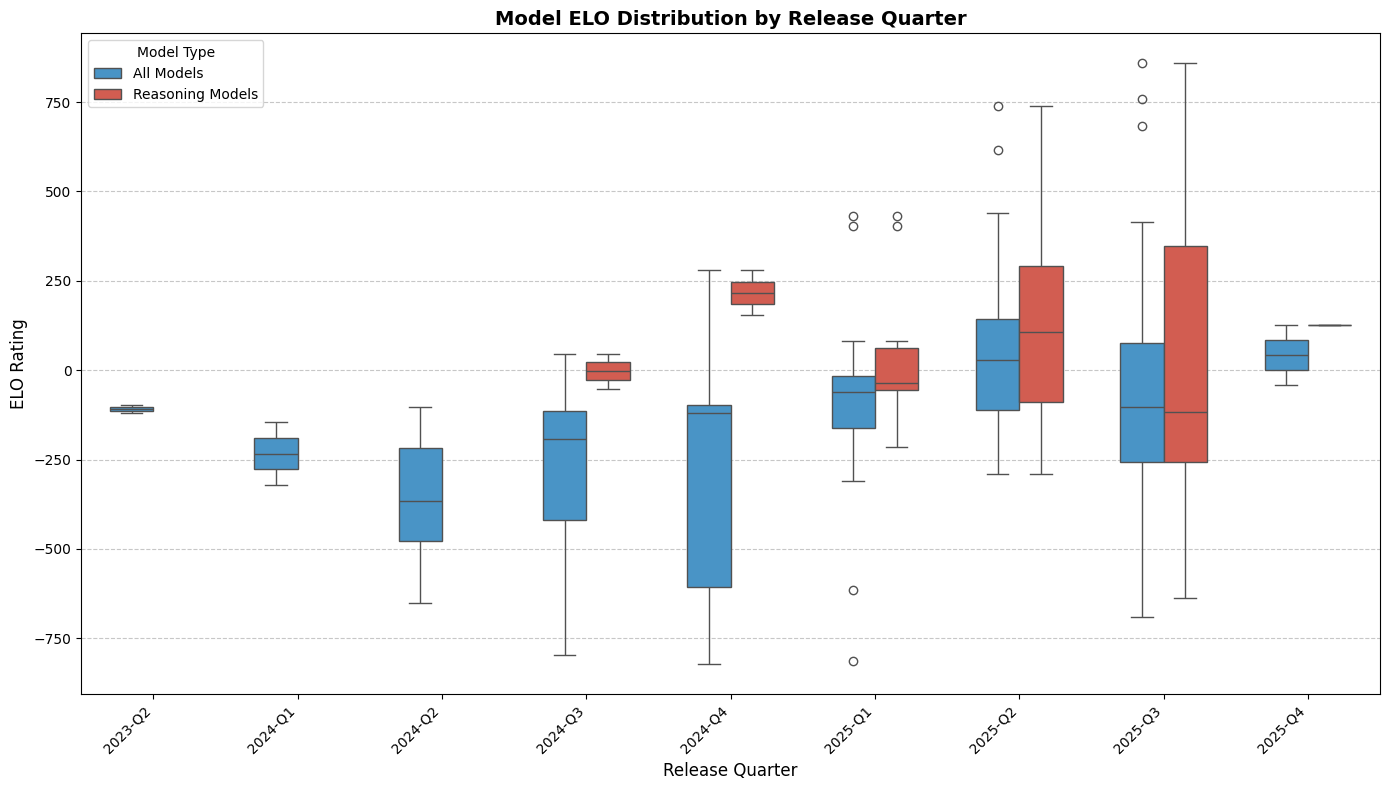


Summary Statistics by Quarter:

--- All Models ---
              count  median   mean    std
year_quarter                             
2023-Q2           2  -108.8 -108.8   15.5
2024-Q1           2  -233.8 -233.8  124.5
2024-Q2           7  -366.9 -359.4  198.0
2024-Q3           8  -193.1 -291.1  298.4
2024-Q4           9  -120.5 -286.3  392.7
2025-Q1          19   -62.4  -97.4  283.5
2025-Q2          17    29.3   89.3  284.4
2025-Q3          22  -102.1  -29.4  413.8
2025-Q4           2    42.3   42.3  119.2

--- Reasoning Models Only ---
              count  median   mean    std
year_quarter                             
2024-Q3           2    -3.0   -3.0   69.8
2024-Q4           2   216.5  216.5   88.4
2025-Q1          10   -35.0   34.6  218.8
2025-Q2          12   107.0  145.1  314.9
2025-Q3          17  -117.0   20.2  440.4
2025-Q4           1   126.6  126.6    NaN


In [4]:
# Sort quarters chronologically
quarters_sorted = sorted(merged_df['year_quarter'].unique())

# Create dataframes for all models and reasoning models only
all_models_df = merged_df.copy()
all_models_df['category'] = 'All Models'

reasoning_df = merged_df[merged_df['reasoning_status'] == 'reasoning'].copy()
reasoning_df['category'] = 'Reasoning Models'

# Combine for plotting
plot_df = pd.concat([all_models_df, reasoning_df], ignore_index=True)

# Set up the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Create box plot with hue for category
sns.boxplot(
    data=plot_df,
    x='year_quarter',
    y='elo',
    hue='category',
    order=quarters_sorted,
    palette={'All Models': '#3498db', 'Reasoning Models': '#e74c3c'},
    ax=ax,
    width=0.6
)

# Customize the plot
ax.set_xlabel('Release Quarter', fontsize=12)
ax.set_ylabel('ELO Rating', fontsize=12)
ax.set_title('Model ELO Distribution by Release Quarter', fontsize=14, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add legend
ax.legend(title='Model Type', loc='upper left')

# Add grid for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

# Print summary statistics per quarter
print("\nSummary Statistics by Quarter:")
print("\n--- All Models ---")
print(merged_df.groupby('year_quarter')['elo'].agg(['count', 'median', 'mean', 'std']).round(1))

print("\n--- Reasoning Models Only ---")
reasoning_only = merged_df[merged_df['reasoning_status'] == 'reasoning']
if len(reasoning_only) > 0:
    print(reasoning_only.groupby('year_quarter')['elo'].agg(['count', 'median', 'mean', 'std']).round(1))
else:
    print("No reasoning models found")


## Best ELO Per Month

Top performing model in each month.


In [5]:
# Add year_month column (format: YYYY-MM from date_released)
merged_df['year_month'] = merged_df['date_released']

# Get the best model per month
best_per_month = merged_df.loc[merged_df.groupby('year_month')['elo'].idxmax()]
best_per_month = best_per_month[['year_month', 'Player', 'elo', 'reasoning_status']].sort_values('year_month')

print("Best ELO Per Month:")
print("-" * 80)
for _, row in best_per_month.iterrows():
    reasoning_tag = " [reasoning]" if row['reasoning_status'] == 'reasoning' else ""
    print(f"{row['year_month']:10} | {row['Player']:45} | ELO: {row['elo']:>7.1f}{reasoning_tag}")


Best ELO Per Month:
--------------------------------------------------------------------------------
2023-06    | gpt-4-32k-0613                                | ELO:   -97.8
2024-03    | claude-3-opus                                 | ELO:  -145.7
2024-04    | gpt-4-turbo-2024-04-09                        | ELO:  -103.8
2024-05    | gpt-4o-2024-05-13                             | ELO:  -157.7
2024-06    | gemma-2-27b-it@q6_k_l                         | ELO:  -412.4
2024-07    | claude-3-5-sonnet                             | ELO:  -134.4
2024-08    | gpt-4o-2024-08-06                             | ELO:  -133.9
2024-09    | o1-preview-2024-09-12                         | ELO:    46.3 [reasoning]
2024-10    | claude-3-5-sonnet-v2                          | ELO:   -98.7
2024-11    | gpt-4o-2024-11-20                             | ELO:  -108.1
2024-12    | o1-2024-12-17-medium                          | ELO:   279.0 [reasoning]
2025-01    | o3-mini-2025-01-31-high                       | 

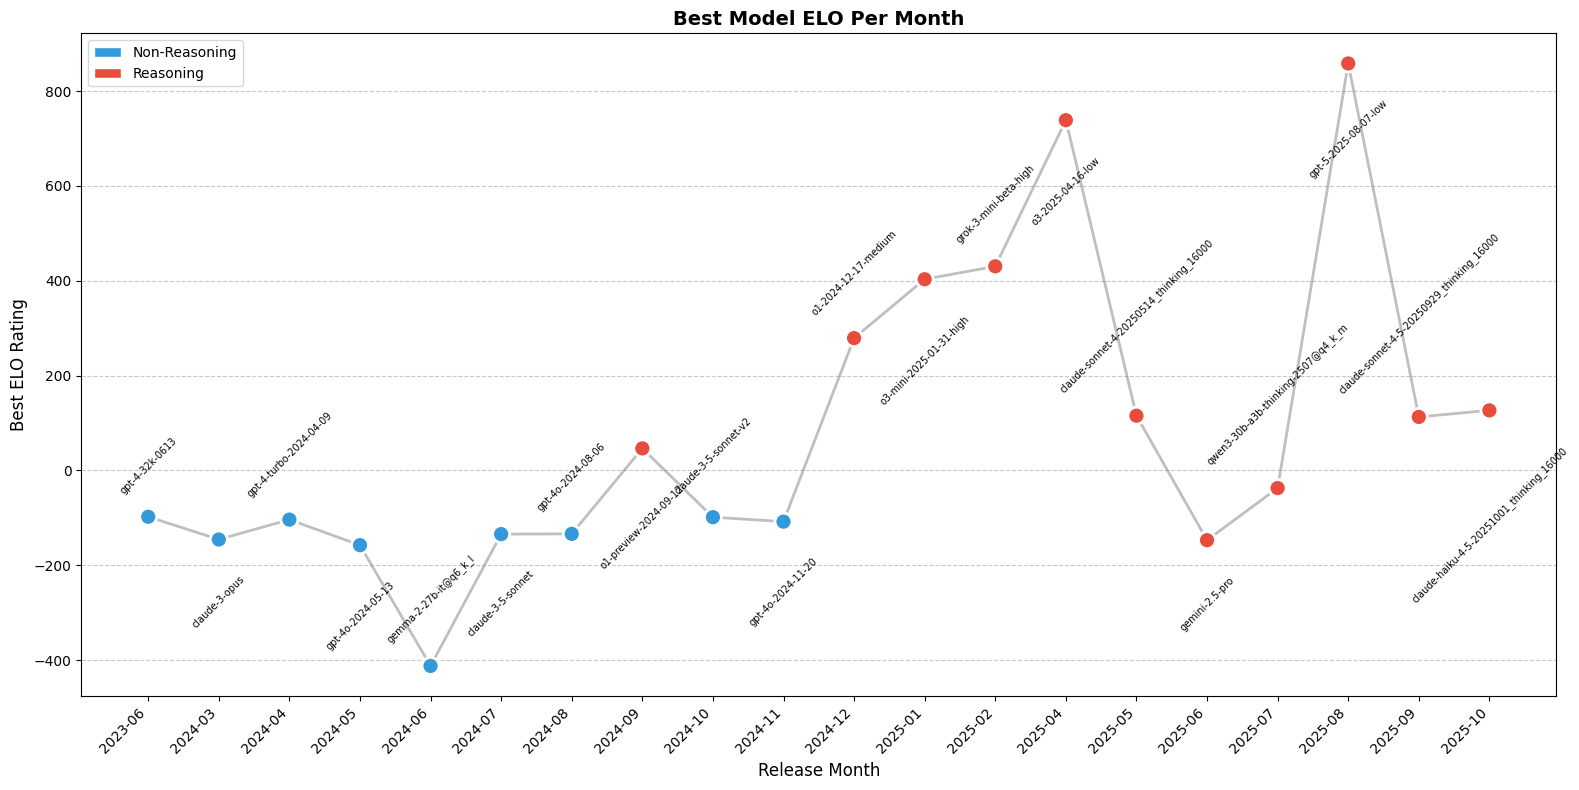

In [6]:
# Plot best ELO per month with model names
fig, ax = plt.subplots(figsize=(16, 8))

months_sorted = sorted(best_per_month['year_month'].unique())
best_sorted = best_per_month.set_index('year_month').loc[months_sorted].reset_index()

# Color based on reasoning status
colors = ['#e74c3c' if r == 'reasoning' else '#3498db' for r in best_sorted['reasoning_status']]

# Plot line and points
ax.plot(range(len(months_sorted)), best_sorted['elo'], 'o-', color='gray', alpha=0.5, linewidth=2, markersize=10, zorder=1)
ax.scatter(range(len(months_sorted)), best_sorted['elo'], c=colors, s=150, zorder=2, edgecolors='white', linewidths=2)

# Add model name labels
for i, row in best_sorted.iterrows():
    # Alternate label positions to avoid overlap
    offset = 15 if i % 2 == 0 else -25
    va = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(
        row['Player'], 
        (i, row['elo']),
        textcoords="offset points",
        xytext=(0, offset),
        ha='center',
        va=va,
        fontsize=7,
        rotation=45
    )

ax.set_xticks(range(len(months_sorted)))
ax.set_xticklabels(months_sorted, rotation=45, ha='right')
ax.set_xlabel('Release Month', fontsize=12)
ax.set_ylabel('Best ELO Rating', fontsize=12)
ax.set_title('Best Model ELO Per Month', fontsize=14, fontweight='bold')

# Add legend for reasoning vs non-reasoning
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', edgecolor='white', label='Non-Reasoning'),
    Patch(facecolor='#e74c3c', edgecolor='white', label='Reasoning')
]
ax.legend(handles=legend_elements, loc='upper left')

ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()


## Per-Year Statistics

Aggregated statistics by year for all models and reasoning models.


In [7]:
# Extract year from year_quarter
merged_df['year'] = merged_df['year_quarter'].str.split('-').str[0]

print("Per-Year Statistics:")
print("\n--- All Models ---")
yearly_all = merged_df.groupby('year')['elo'].agg(
    count='count',
    min='min',
    Q1=lambda x: x.quantile(0.25),
    median='median',
    Q3=lambda x: x.quantile(0.75),
    max='max',
    mean='mean',
    std='std'
).round(1)
print(yearly_all)

print("\n--- Reasoning Models Only ---")
reasoning_only = merged_df[merged_df['reasoning_status'] == 'reasoning']
if len(reasoning_only) > 0:
    yearly_reasoning = reasoning_only.groupby('year')['elo'].agg(
        count='count',
        min='min',
        Q1=lambda x: x.quantile(0.25),
        median='median',
        Q3=lambda x: x.quantile(0.75),
        max='max',
        mean='mean',
        std='std'
    ).round(1)
    print(yearly_reasoning)
else:
    print("No reasoning models found")


Per-Year Statistics:

--- All Models ---
      count    min     Q1  median     Q3    max   mean    std
year                                                         
2023      2 -119.8 -114.3  -108.8 -103.3  -97.8 -108.8   15.5
2024     26 -822.8 -571.0  -265.0 -111.2  279.0 -303.4  292.8
2025     60 -812.4 -191.9   -40.0  110.6  858.2  -14.9  336.4

--- Reasoning Models Only ---
      count    min     Q1  median     Q3    max   mean    std
year                                                         
2024      4  -52.4   21.7   100.2  185.3  279.0  106.7  142.5
2025     40 -636.9 -191.9   -35.0  267.4  858.2   63.9  348.9


## Per-Quarter Game Duration

Average game duration statistics by quarter.


In [8]:
print("Per-Quarter Game Duration Statistics:")
print("\n--- All Models ---")
quarterly_duration_all = merged_df.groupby('year_quarter')['game_duration'].agg(
    count='count',
    min='min',
    Q1=lambda x: x.quantile(0.25),
    median='median',
    Q3=lambda x: x.quantile(0.75),
    max='max',
    mean='mean',
    std='std'
).round(3)
print(quarterly_duration_all)

print("\n--- Reasoning Models Only ---")
reasoning_only = merged_df[merged_df['reasoning_status'] == 'reasoning']
if len(reasoning_only) > 0:
    quarterly_duration_reasoning = reasoning_only.groupby('year_quarter')['game_duration'].agg(
        count='count',
        min='min',
        Q1=lambda x: x.quantile(0.25),
        median='median',
        Q3=lambda x: x.quantile(0.75),
        max='max',
        mean='mean',
        std='std'
    ).round(3)
    print(quarterly_duration_reasoning)
else:
    print("No reasoning models found")


Per-Quarter Game Duration Statistics:

--- All Models ---
              count    min     Q1  median     Q3    max   mean    std
year_quarter                                                         
2023-Q2           2  0.993  0.995   0.996  0.998  1.000  0.996  0.005
2024-Q1           2  0.555  0.633   0.712  0.790  0.868  0.712  0.221
2024-Q2           7  0.328  0.392   0.567  0.851  0.985  0.624  0.276
2024-Q3           8  0.135  0.545   0.840  0.937  0.995  0.706  0.319
2024-Q4           9  0.294  0.379   0.980  0.988  1.000  0.712  0.330
2025-Q1          19  0.430  0.884   0.988  1.000  1.000  0.891  0.186
2025-Q2          17  0.490  0.736   0.990  1.000  1.000  0.879  0.162
2025-Q3          22  0.063  0.417   0.875  0.995  1.000  0.656  0.364
2025-Q4           2  0.973  0.980   0.986  0.993  1.000  0.986  0.019

--- Reasoning Models Only ---
              count    min     Q1  median     Q3   max   mean    std
year_quarter                                                        
202

## Per-Month Game Duration

Average and best game duration statistics by month.


In [ ]:
# Average game duration per month
print("Average Game Duration Per Month:")
print("-" * 80)
avg_duration_per_month = merged_df.groupby('year_month')['game_duration'].mean().sort_index()
for month, avg in avg_duration_per_month.items():
    print(f"{month:10} | Average Duration: {avg:.4f}")

print("\n")

# Best (highest) game duration per month
print("Best Game Duration Per Month:")
print("-" * 80)
best_duration_per_month = merged_df.loc[merged_df.groupby('year_month')['game_duration'].idxmax()]
best_duration_per_month = best_duration_per_month[['year_month', 'Player', 'game_duration', 'reasoning_status']].sort_values('year_month')

for _, row in best_duration_per_month.iterrows():
    reasoning_tag = " [reasoning]" if row['reasoning_status'] == 'reasoning' else ""
    print(f"{row['year_month']:10} | {row['Player']:45} | Duration: {row['game_duration']:.4f}{reasoning_tag}")


In [ ]:
# Plot average and best game duration per month
fig, ax = plt.subplots(figsize=(16, 8))

months_sorted = sorted(merged_df['year_month'].unique())

# Calculate average duration per month
avg_duration = merged_df.groupby('year_month')['game_duration'].mean().reindex(months_sorted)

# Get best duration per month
best_duration_df = best_duration_per_month.set_index('year_month').reindex(months_sorted)

# Plot average duration as bars
x_pos = range(len(months_sorted))
bars = ax.bar(x_pos, avg_duration.values, alpha=0.6, color='#3498db', label='Average Duration', width=0.6)

# Plot best duration as line with points
ax.plot(x_pos, best_duration_df['game_duration'], 'o-', color='#e74c3c', linewidth=2, markersize=10, label='Best Duration', zorder=3)

# Color best duration points by reasoning status
colors = ['#e74c3c' if r == 'reasoning' else '#27ae60' for r in best_duration_df['reasoning_status']]
ax.scatter(x_pos, best_duration_df['game_duration'], c=colors, s=120, zorder=4, edgecolors='white', linewidths=2)

# Add model name labels for best duration
for i, (month, row) in enumerate(best_duration_df.iterrows()):
    offset = 0.03 if i % 2 == 0 else -0.05
    va = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(
        row['Player'], 
        (i, row['game_duration'] + offset),
        ha='center',
        va=va,
        fontsize=6,
        rotation=45
    )

ax.set_xticks(x_pos)
ax.set_xticklabels(months_sorted, rotation=45, ha='right')
ax.set_xlabel('Release Month', fontsize=12)
ax.set_ylabel('Game Duration', fontsize=12)
ax.set_title('Game Duration Per Month (Average vs Best)', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.15)

# Add legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Patch(facecolor='#3498db', alpha=0.6, label='Average Duration'),
    Line2D([0], [0], marker='o', color='#e74c3c', label='Best Duration (Reasoning)', markersize=10, linestyle='-'),
    Line2D([0], [0], marker='o', color='#27ae60', label='Best Duration (Non-Reasoning)', markersize=10, linestyle='None')
]
ax.legend(handles=legend_elements, loc='lower right')

ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()
